# 1. Setup

In [0]:
!pip install git+https://github.com/usgs/geomag-algorithms.git
!pip install git+https://github.com/samiriff/mars-ode-data-access.git

  Cloning https://github.com/usgs/geomag-algorithms.git to /tmp/pip-req-build-cin3hyce
  Running command git clone -q https://github.com/usgs/geomag-algorithms.git /tmp/pip-req-build-cin3hyce
     |████████████████████████████████| 23.9MB 34.9MB/s 
     |████████████████████████████████| 215kB 36.5MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-povwywcx/wheels/dc/8b/cb/0141ac2aa76db65e2037c96bf61b63c26a64a1eb4ddb6f7eeb
  Stored in directory: /root/.cache/pip/wheels/11/d6/40/c448464ae42229b2f9fb46b71be0213e10e9628346b7f1198f
  Stored in directory: /root/.cache/pip/wheels/89/40/f5/7b4f2285aca871b5173887a6c69127210d92806c0d3a977e51
Successfully built geomag-algorithms obspy pycurl
  Cloning https://github.com/samiriff/mars-ode-data-access.git to /tmp/pip-req-build-ytzadq53
  Running command git clone -q https://github.com/samiriff/mars-ode-data-access.git /tmp/pip-req-build-ytzadq53
     |████████████████████████████████| 19.7MB 6.1MB/s 
     |████████████████████████████████| 20.

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


# 2. Imports

In [0]:
from ode_data_access.query_processor import QueryProcessor
from ode_data_access.query_result_processor import QueryResultProcessor
import numpy as np
from fastai.vision import *
from fastai.imports import *
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import PIL
from pathlib import Path
import cv2
import json
from tqdm import tqdm_notebook as tqdm
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# 3. Load Trained U-Net Model and Initialize Prediction utilities

In [0]:
!wget -O trained_unet.pkl https://files.slack.com/files-pri/TJRDXSH3L-FLE3AS5PC/download/trained_unet_762394.pkl?pub_secret=814d8c3b0a

--2019-07-27 11:18:34--  https://files.slack.com/files-pri/TJRDXSH3L-FLE3AS5PC/download/trained_unet_762394.pkl?pub_secret=814d8c3b0a
Resolving files.slack.com (files.slack.com)... 13.249.2.166
Connecting to files.slack.com (files.slack.com)|13.249.2.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129212486 (123M) [application/octet-stream]
Saving to: ‘trained_unet.pkl’

trained_unet.pkl    100%[===================>] 123.23M  7.65MB/s    in 17s     

2019-07-27 11:18:52 (7.31 MB/s) - ‘trained_unet.pkl’ saved [129212486/129212486]



In [0]:
def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [0]:
learn = load_learner('.', 'trained_unet.pkl')

In [0]:
classes = ['_background_', 'Crater', 'Dark Dune', 'Slope Streak', 'Bright Dune', 'Impact Ejecta', 'Swiss Cheese', 'Spider']
test_data = ImageDataBunch.single_from_classes('.', classes, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [0]:
tmp_path = Path('tmp')
if not os.path.exists(tmp_path):
  os.mkdir(tmp_path)

In [0]:
results_path = Path('results')
if not os.path.exists(results_path):
  os.mkdir(results_path)

In [0]:
def get_img_info(img_name):
  img = mpimg.imread(img_name)
  rows, cols = map(lambda x : x // 224, img.shape)
  img = PIL.Image.fromarray(img)  
  return img, rows, cols

In [0]:
def get_prediction(img):
  result_img = None
  pred_img = None
  for row in (range(cols)):
    horizontal_result_img = None
    horizontal_pred_img = None
    for col in (range(rows)):
      area = (224 * row, 224 * col, 224 * (row + 1), 224 * (col + 1))
      cropped_img = img.crop(area)
      resized_img = cropped_img.resize((224, 224))
      resized_img.save(tmp_path/'test.jpg')

      pred = learn.predict(open_image(tmp_path/'test.jpg'))

      background = np.array(resized_img)
      foreground = np.uint8(np.squeeze(pred[0].data.numpy()) * 255)
      blended_img = cv2.addWeighted(background, 1, foreground, 0.5, 0)

      if horizontal_result_img is None:
        horizontal_result_img = blended_img
        horizontal_pred_img = np.squeeze(pred[0].data.numpy())
      else:
        horizontal_result_img = np.concatenate((horizontal_result_img, blended_img), axis=0)
        horizontal_pred_img = np.concatenate((horizontal_pred_img, np.squeeze(pred[0].data.numpy())), axis=0)
    if result_img is None:
      result_img = horizontal_result_img
      pred_img = horizontal_pred_img
    else:
      result_img = np.concatenate((result_img, horizontal_result_img), axis=1)
      pred_img = np.concatenate((pred_img, horizontal_pred_img), axis=1)
  return result_img, pred_img

In [0]:
def get_result_name(img_name):
  tokens = img_name.split('.')
  tokens.insert(-1, 'result')
  return '.'.join(tokens)

In [0]:
def write_result(img_name, result_img):
  result_name = get_result_name(img_name)
  cv2.imwrite(str(results_path/result_name), result_img)

In [0]:
def write_img_classes_result(img_classes_json):
  with open(results_path/'result.json', 'w') as f:
    json.dump(img_classes_json, f, indent=2)

In [0]:
def get_img_classes_result():
  with open(results_path/'result.json', 'r') as json_file:
    data = json.load(json_file)
    return data

In [0]:
def get_image_classes(img):
  code_to_class_map = {
      0 : 'Background',
      1 : 'Crater',
      2 : 'Dark Dune',
      3 : 'Slope Streak',
      4 : 'Bright Dune',
      5 : 'Impact Ejecta',
      6 : 'Swiss Cheese',
      7 : 'Spider'
  }
  mapper = lambda x : code_to_class_map[x]
  codes = np.unique(img)[1:]
  if codes.shape[0] == 0:
    return []
  return np.vectorize(mapper)(codes).tolist()

In [0]:
def dfs(img, row, col, visited):
  if row < 0 or col < 0 or row >= img.shape[0] or col >= img.shape[1]:
    return
  
  visited[row][col] = 1
  
  if img[row][col] == 0 or visited[row][col] == 1:
    return
  
  dfs(img, row + 1, col, visited)
  dfs(img, row - 1, col, visited)
  dfs(img, row, col + 1, visited)
  dfs(img, row, col - 1, visited)

In [0]:
def get_object_count(img):
  count = 0
  visited = np.zeros_like(dummy)
  for row in range(img.shape[0]):
    for col in range(img.shape[1]):
      if img[row][col] != 0 and visited[row][col] != 1:
        dfs(img, row, col, visited)
        count += 1
  return count

# 4. Query Processing for Mars ODE
- Run the following cells with different query parameters to download the required images
- Once you have got all the results you require, you can pass them through the model

In [0]:
!wget -O unet_dataset.zip https://files.slack.com/files-pri/TJRDXSH3L-FL91UDJFR/download/unet_dataset.zip?pub_secret=4ec1f235fb

--2019-07-27 11:19:15--  https://files.slack.com/files-pri/TJRDXSH3L-FL91UDJFR/download/unet_dataset.zip?pub_secret=4ec1f235fb
Resolving files.slack.com (files.slack.com)... 13.249.2.166
Connecting to files.slack.com (files.slack.com)|13.249.2.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134746555 (129M) [application/zip]
Saving to: ‘unet_dataset.zip’

unet_dataset.zip    100%[===================>] 128.50M  5.76MB/s    in 22s     

2019-07-27 11:19:38 (5.77 MB/s) - ‘unet_dataset.zip’ saved [134746555/134746555]



In [0]:
!unzip -qq unet_dataset.zip 

In [0]:
img_path = Path('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train')

In [0]:
validation_image_names = []
with open(img_path/'valid.txt') as f:
  validation_image_names = [line.strip() for line in f.readlines()]

In [0]:
all_image_names = [file for file in os.listdir(img_path/'JPEGImages') if file.endswith('.jpg')]

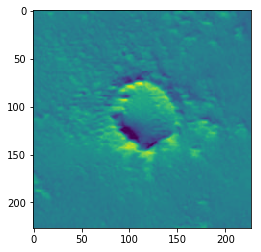

In [0]:
plt.imshow(mpimg.imread(img_path/'JPEGImages'/validation_image_names[0]))

# 5. Prediction

In [0]:
image_names = validation_image_names

In [0]:
image_names = all_image_names

In [0]:
len(image_names)

1674

In [0]:
img_classes_json = {}
for image_name in tqdm(image_names):
  img, rows, cols = get_img_info(img_path/'JPEGImages'/image_name)
  # print('Image =', image_name, ', Image Size =', img.size, ', Rows =', rows, ', Cols =', cols)
  result_img, pred_img = get_prediction(img)
  write_result(image_name, result_img)
  
  img_classes = get_image_classes(pred_img)
  # print('Image Classes =', img_classes)
  img_classes_json[image_name] = img_classes
  
  # print('---')
  
write_img_classes_result(img_classes_json)
print('Task Completed')

Task Completed


# 6. View Results

Image Classes Detected: ['Crater']


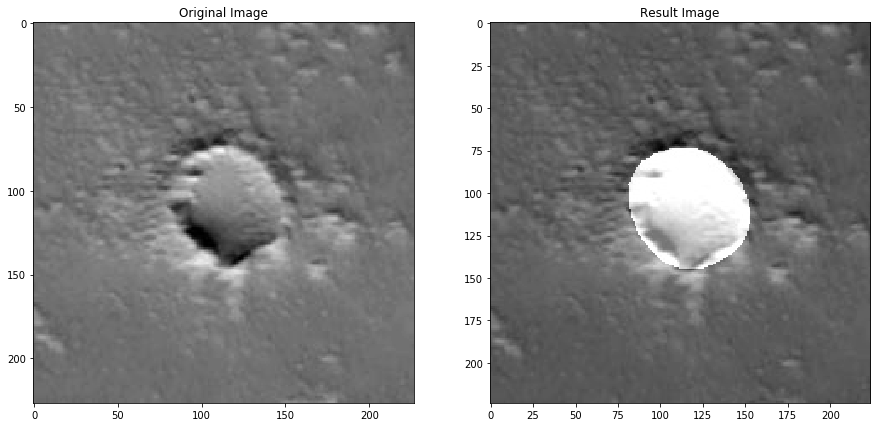

In [0]:
img_name = image_names[0]

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(mpimg.imread(img_path/'JPEGImages'/img_name), cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(mpimg.imread(results_path/get_result_name(img_name)), cmap='gray')
ax[1].set_title('Result Image')
print('Image Classes Detected:', get_img_classes_result()[img_name])

# Evaluation Metrics

In [0]:
def get_ground_truth(img_name):
  npy_filename = img_name.split('.')[0] + '.npy'
  img = np.load(img_path/'SegmentationClass'/npy_filename)
  return get_image_classes(img)

In [0]:
ground_truth_json = {}
for image_name in tqdm(image_names):
  ground_truth_json[image_name] = get_ground_truth(image_name)

In [0]:
y_true = []
y_pred = []
for image_name in image_names:
  ground_truth = ground_truth_json[image_name]
  ground_truth = ground_truth[0] if len(ground_truth) > 0 else ''
  prediction = img_classes_json[image_name]
  prediction = prediction[0] if len(prediction) > 0 else ''
  
  y_true.append(ground_truth)
  y_pred.append(prediction)

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred, labels=["Crater", "Dark Dune", "Slope Streak", "Bright Dune", "Impact Ejecta", "Swiss Cheese", "Spider"])

array([[45,  0,  0,  0,  0,  0,  0],
       [ 0, 45,  0,  0,  0,  0,  0],
       [ 0,  0, 45,  0,  0,  0,  0],
       [ 0,  0,  0, 45,  0,  0,  0],
       [ 0,  0,  1,  5, 33,  0,  2],
       [ 0,  1,  0,  0,  0, 44,  0],
       [ 0,  0,  1,  0,  0,  0, 44]])

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred, labels=["Crater", "Dark Dune", "Slope Streak", "Bright Dune", "Impact Ejecta", "Swiss Cheese", "Spider"])

array([[250,   0,   0,   0,   0,   0,   0],
       [  1, 249,   0,   0,   0,   0,   0],
       [  0,   0, 250,   0,   0,   0,   0],
       [  0,   0,   0, 246,   1,   0,   0],
       [  1,   0,   7,  12, 135,   0,   2],
       [  0,   1,   0,   1,   0, 248,   0],
       [  0,   0,   3,   0,   0,   0, 247]])

In [0]:
from sklearn.metrics import classification_report
target_names = ["", "Crater", "Dark Dune", "Slope Streak", "Bright Dune", "Impact Ejecta", "Swiss Cheese", "Spider"]
print(classification_report(y_true, y_pred, target_names=target_names))

               precision    recall  f1-score   support

                    0.00      0.00      0.00         0
       Crater       0.90      1.00      0.95        45
    Dark Dune       1.00      1.00      1.00        45
 Slope Streak       0.98      1.00      0.99        45
  Bright Dune       1.00      0.73      0.85        45
Impact Ejecta       0.96      1.00      0.98        45
 Swiss Cheese       0.96      0.98      0.97        45
       Spider       1.00      0.98      0.99        45

     accuracy                           0.96       315
    macro avg       0.85      0.84      0.84       315
 weighted avg       0.97      0.96      0.96       315



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
from sklearn.metrics import classification_report
target_names = ["", "Crater", "Dark Dune", "Slope Streak", "Bright Dune", "Impact Ejecta", "Swiss Cheese", "Spider"]
print(classification_report(y_true, y_pred, target_names=target_names))

               precision    recall  f1-score   support

                    0.00      0.00      0.00         4
       Crater       0.94      1.00      0.97       247
    Dark Dune       0.99      1.00      1.00       250
 Slope Streak       1.00      1.00      1.00       250
  Bright Dune       0.99      0.78      0.87       173
Impact Ejecta       0.96      1.00      0.98       250
 Swiss Cheese       0.99      0.99      0.99       250
       Spider       1.00      0.99      0.99       250

     accuracy                           0.97      1674
    macro avg       0.86      0.84      0.85      1674
 weighted avg       0.98      0.97      0.97      1674



In [0]:
for image_name in image_names:
  ground_truth = ground_truth_json[image_name]
  prediction = img_classes_json[image_name]
  is_tp = not set(ground_truth).isdisjoint(prediction)

In [0]:
with open('ground_truth.json', 'w') as f:
    json.dump(ground_truth_json, f, indent=2)

# Extras

## IMPORTANT: FOR REFERENCE ONLY - DO NOT RUN THESE CELLS

In [0]:
#@title Landing Site Coordinates
with open('../Landing_sites.csv', 'r') as f:
  lines = f.readlines()
  formatted_lines = []
  regex = re.compile(".*?\((.*?)\)")
  for line in lines:
    formatted_line = line.strip()
    formatted_line = re.sub("[\(\[].*?[\)\]]", "", formatted_line)
    formatted_lines.append(formatted_line.split(', '))
    
landing_sites = pd.DataFrame(formatted_lines, columns=['Mission', 'Latitude', 'Longitude', 'Status'])
landing_sites['Latitude'] = landing_sites['Latitude'].apply(convert_latitude)
landing_sites['Longitude'] = landing_sites['Longitude'].apply(convert_longitude)
landing_sites

,Mission,Latitude,Longitude,Status
0,Mars 2,-45,47.000000,Failed
1,Mars 3,-45,202.000000,Failed
2,Mars 6,-23.9,340.580000,Failed
3,Viking 1,22.48,310.030000,Successful
4,Mars Polar Lander,-76.57,165.200000,Failed
5,Pathfinder,19.33,326.450000,Successful
6,Beagle 2,10.6,90.000000,Failed
7,Spirit,-14.5719,175.478480,Successful
8,Opportunity,-1.9462,354.473400,Successful
9,Phoenix,68.218830,234.250778,Successful
